In [1]:
import glob
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.transforms import Compose, ToTensor, Resize, Normalize, RandomHorizontalFlip, ToPILImage
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader
import torchvision.models as models
import random
import os
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from IPython.core.debugger import set_trace
import pandas as pd
import datetime
import pytz
import seaborn as sns


## 파라미터 설정

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
'''
# 맥 mps 설정
device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")
print(f"현재 디바이스는 {device} 입니다.")
'''

'\n# 맥 mps 설정\ndevice = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")\nprint(f"현재 디바이스는 {device} 입니다.")\n'

In [3]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':50,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE': 64,
    'SEED':41,
    'MEAN' : [0.485, 0.456, 0.406],
    'STD'  : [0.229, 0.224, 0.225],
    'train_magnification':20,
    'test_magnification':20,
}

In [4]:
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
formatted_datetime = current_datetime.strftime("%Y_%m_%d_%I:%M_%p")
print(formatted_datetime)

2023_06_02_03:40_PM


In [5]:
pth_name=f"/data/pthfile/train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}_({formatted_datetime}).pth"
output_name = f"train:{CFG['train_magnification']}X_test:{CFG['test_magnification']}X_epoch:{CFG['EPOCHS']}"
output_path = f"/data/output/output_{output_name}_({formatted_datetime})"
plot_path = f"/data/plot/plot_{output_name}_({formatted_datetime})"
train_data_path = f"/data/PDA_mask_img/train/{CFG['train_magnification']}X/**/*.png"
test_data_path = f"/data/PDA_mask_img/test_mask/{CFG['test_magnification']}X/**/*.png"
val_data_path = f"/data/PDA_mask_img/validation_mask/{CFG['train_magnification']}X/**/*.png"


print(f"pth_name:{pth_name}")
print(f"output_path:{output_path}")
print(f"plot_path:{plot_path}")
print(f"train_data_path:{train_data_path}")
print(f"test_data_path:{test_data_path}")
print(f"test_data_path:{val_data_path}")

pth_name:/data/pthfile/train:20X_test:20X_epoch:50_(2023_06_02_03:40_PM).pth
output_path:/data/output/output_train:20X_test:20X_epoch:50_(2023_06_02_03:40_PM)
plot_path:/data/plot/plot_train:20X_test:20X_epoch:50_(2023_06_02_03:40_PM)
train_data_path:/data/PDA_mask_img/train/20X/**/*.png
test_data_path:/data/PDA_mask_img/test_mask/20X/**/*.png
test_data_path:/data/PDA_mask_img/validation_mask/20X/**/*.png


In [6]:
# 시드 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## 데이터 경로지정

In [7]:
train_path_list = sorted(glob.glob(train_data_path))
train_mask_path = train_path_list[0::2]
train_img_path = train_path_list[1::2]
train_mask_path[:5]

['/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10073,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10338,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=10603,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11663,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/train/20X/C3L-00017-22/C3L-00017-22 [d=1.01174,x=10073,y=11928,w=518,h=518]-labelled.png']

In [8]:
test_path_list = sorted(glob.glob(test_data_path))
test_mask_path = test_path_list[0::2]
test_img_path = test_path_list[1::2]
test_mask_path[:5]

['/data/PDA_mask_img/test_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=15022,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=15540,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=16058,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=16576,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/test_mask/20X/C3L-00277-22/C3L-00277-22 [d=1.01174,x=10360,y=18130,w=518,h=518]-labelled.png']

In [9]:
val_path_list = sorted(glob.glob(val_data_path))
val_mask_path = val_path_list[0::2]
val_img_path = val_path_list[1::2]
val_mask_path[:5]

['/data/PDA_mask_img/validation_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3108,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=3626,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4144,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10360,y=4662,w=518,h=518]-labelled.png',
 '/data/PDA_mask_img/validation_mask/20X/C3L-01637-21/C3L-01637-21 [d=1.01174,x=10878,y=3626,w=518,h=518]-labelled.png']

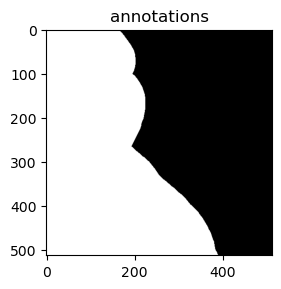

In [12]:
annotation = cv2.imread(train_mask_path[5])
plt.subplot(1,2,1)
plt.title("annotations")
plt.imshow(annotation)

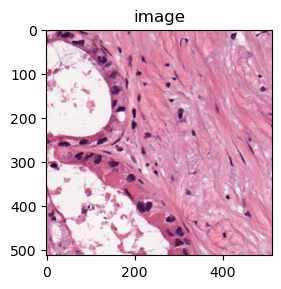

In [13]:
image = cv2.imread(train_img_path[5])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1,2,2)
plt.title("image")
plt.imshow(image)


In [22]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, img_path, mask_path, img_transform = None, mask_transform = None):
        self.images = img_path
        self.annotations = mask_path
        
        n_samples =  len(self.images)
        
        # 데이터 미리 섞어줌
        np.random.seed(CFG['SEED'])
        idxs = np.random.permutation(range(n_samples))
        
        self.images = np.array(self.images)[idxs]
        self.annotations = np.array(self.annotations)[idxs]

        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images) # 데이터셋 길이

    
    def __getitem__(self, i):
        images = Image.open(self.images[i])
        images = self.img_transform(images)
        masks = Image.open(self.annotations[i]).convert('L')
        masks = self.mask_transform(masks)
        return images, masks

In [15]:
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(pretrained=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)
        x1 = self.encoder.maxpool(x1)

        x2 = self.encoder.layer1(x1)
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = self.relu(self.conv1(x))

        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = self.relu(self.conv2(x))

        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = self.relu(self.conv3(x))

        x = self.conv4(x)

        # Resize to 512x512
        x = nn.functional.interpolate(x, size=(512, 512), mode='bilinear', align_corners=False)

        return x

## 데이터 불러오기

In [23]:
mask_transform = Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                    ToTensor()])


In [24]:
img_transform = {
    'train' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD']),
                      RandomHorizontalFlip()]),
    'val' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD'])]),
    'test' : Compose([Resize((CFG['IMG_SIZE'],CFG['IMG_SIZE'])),
                      ToTensor(),
                      Normalize(mean=CFG['MEAN'], std = CFG['STD'])])
}

In [25]:
# 학습용 데이터
train_set = CustomDataset(img_path = train_img_path,
                          mask_path = train_mask_path,
                          mask_transform = mask_transform,
                          img_transform=img_transform['train'])

val_set = CustomDataset(img_path = val_img_path,
                         mask_path= val_mask_path,
                         mask_transform = mask_transform,
                         img_transform=img_transform['val'])
# 테스트 데이터
test_set = CustomDataset(img_path = test_img_path,
                         mask_path=test_mask_path,
                         mask_transform = mask_transform,
                         img_transform=img_transform['test'])

In [26]:
train_loader = DataLoader(train_set, batch_size = CFG["BATCH_SIZE"], shuffle = True)
val_loader = DataLoader(val_set, batch_size = CFG["BATCH_SIZE"])
test_loader = DataLoader(test_set, batch_size = CFG["BATCH_SIZE"])

In [27]:
print(f"train_data : {len(train_set)} / val_data : {len(val_set)} / test_data : {len(test_set)}")

train_data : 2475 / val_data : 81 / test_data : 445


## 학습

In [28]:
# 학습 파라미터
model = UNet(num_classes=1).to(device)
model = nn.DataParallel(model)
optimizer = Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)
criterion = nn.BCEWithLogitsLoss().to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
def dice_score(pred, target, smooth=1e-6):
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

In [30]:
# 평균값 계산
class AverageMeter: 
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
class EarlyStop:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
        elif val_score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_score
            self.counter = 0

In [32]:
loss_meter = AverageMeter()
score_meter = AverageMeter()
early_stopping = EarlyStop(patience = 20, delta = 0)

In [33]:
def validation(model, criterion, val_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(val_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())

        val_loss_mean = loss_meter.avg
        val_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    return val_loss_mean, val_score_mean

In [34]:
def train(model, criterion, optimizer, train_loader, val_loader, scheduler, device):
    best_score = 0
    best_model = None
    result_arr = np.empty((0,4), float)
    columns = []
    model.train()
    for epoch in range(CFG["EPOCHS"]):
        try:
            for img, label in tqdm(train_loader):
                optimizer.zero_grad()
                out = model(img.to(device))
                out = torch.squeeze(out)
                pred = torch.ge(out.sigmoid(), 0.5).float()
                label = torch.squeeze(label).to(device)
                score = dice_score(pred, label)
                loss = criterion(out, label.type(torch.FloatTensor).to(device))

                loss_meter.update(loss.item())
                score_meter.update(score.item())

                loss.backward()
                optimizer.step()
                
            train_loss_mean = loss_meter.avg
            train_score_mean = score_meter.avg
            loss_meter.reset()
            score_meter.reset()
            val_loss, val_score = validation(model, criterion, val_loader, device)

            print(f"epoch{epoch+1}: Train_loss:{train_loss_mean} Train_score:{train_score_mean} Val_loss:{val_loss} Val_score:{val_score}")
            result_arr = np.append(result_arr, np.array([[train_loss_mean,train_score_mean, val_loss, val_score]]), axis = 0)
            if scheduler is not None:
                scheduler.step(val_score)
                  
            if best_score < val_score:
                best_score = val_score
                best_model = model
                
            early_stopping(val_score)
            if early_stopping.early_stop:
                columns.append(f"epoch:{epoch+1}")
                print("Early stopping!")
                break
        except KeyboardInterrupt:
            best_model = model
        columns.append(f"epoch:{epoch+1}")
    return best_model, result_arr, columns

## Run

In [35]:
infer_model, result, columns = train(model, criterion, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch1: Train_loss:0.4606035542793763 Train_score:0.6380676346749389 Val_loss:0.539773017168045 Val_score:0.4986490458250046


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch2: Train_loss:0.6809601928943243 Train_score:0.5520435548745669 Val_loss:0.5869469344615936 Val_score:0.2812918946146965


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch3: Train_loss:0.5212038602584448 Train_score:0.6693462408505954 Val_loss:0.5748192667961121 Val_score:0.46775056421756744


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch4: Train_loss:0.49936944781205594 Train_score:0.6886780124444228 Val_loss:0.548894464969635 Val_score:0.5783438682556152


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch5: Train_loss:0.4530756358916943 Train_score:0.7218906543193719 Val_loss:0.5667795836925507 Val_score:0.4735986590385437


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch6: Train_loss:0.41806959876647365 Train_score:0.7487941812246274 Val_loss:0.4825701117515564 Val_score:0.5869599282741547


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch7: Train_loss:0.4118700875685765 Train_score:0.7497281172336676 Val_loss:0.742900937795639 Val_score:0.6189654469490051


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch8: Train_loss:0.4179498224686354 Train_score:0.754382462073595 Val_loss:0.5744872987270355 Val_score:0.4070917218923569


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch9: Train_loss:0.4051101444623409 Train_score:0.7489974101384481 Val_loss:0.6508939564228058 Val_score:0.602654367685318


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch10: Train_loss:0.4001127152870863 Train_score:0.7531718764549646 Val_loss:0.6710435748100281 Val_score:0.62965127825737


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch11: Train_loss:0.3785630090114398 Train_score:0.7690003560139582 Val_loss:0.5193527340888977 Val_score:0.6552295088768005


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch12: Train_loss:0.3784365164927947 Train_score:0.7650365462669959 Val_loss:0.5653554499149323 Val_score:0.6463025808334351


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch13: Train_loss:0.3699372082184523 Train_score:0.7720294885146313 Val_loss:0.4998600035905838 Val_score:0.6638774275779724


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch14: Train_loss:0.3635915395541069 Train_score:0.7799085027132279 Val_loss:0.481161892414093 Val_score:0.635613203048706


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch15: Train_loss:0.38345507933543277 Train_score:0.766537484450218 Val_loss:0.5306771099567413 Val_score:0.4797969162464142


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch16: Train_loss:0.37366762451636487 Train_score:0.7688510234539325 Val_loss:0.5648137032985687 Val_score:0.6762032806873322


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch17: Train_loss:0.3679161507349748 Train_score:0.7737511579806988 Val_loss:0.4811685234308243 Val_score:0.6064632534980774


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch18: Train_loss:0.34427892779692626 Train_score:0.792780108940907 Val_loss:0.6325528025627136 Val_score:0.6578361392021179


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch19: Train_loss:0.34431512157122296 Train_score:0.7885343676958328 Val_loss:0.5226250886917114 Val_score:0.6887511909008026


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch20: Train_loss:0.3310190477432349 Train_score:0.8021012911429772 Val_loss:0.6117279529571533 Val_score:0.6080575287342072


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch21: Train_loss:0.3262674808502197 Train_score:0.8009447715221307 Val_loss:0.5094415545463562 Val_score:0.62015500664711


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch22: Train_loss:0.3085188239048689 Train_score:0.8184589269833688 Val_loss:0.6283275187015533 Val_score:0.6989635229110718


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch23: Train_loss:0.3039830785531264 Train_score:0.8177307477364173 Val_loss:0.6108619868755341 Val_score:0.70012366771698


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch24: Train_loss:0.292534433114223 Train_score:0.8292903181834098 Val_loss:0.5091975331306458 Val_score:0.6425077021121979


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch25: Train_loss:0.2878727553746639 Train_score:0.8320861504628108 Val_loss:0.521494597196579 Val_score:0.7112056016921997


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch26: Train_loss:0.29137282570203143 Train_score:0.829613297413557 Val_loss:0.7043416798114777 Val_score:0.6879182457923889


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch27: Train_loss:0.2715559162390538 Train_score:0.8434280630869743 Val_loss:0.6805920898914337 Val_score:0.7053115963935852


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch28: Train_loss:0.26204231801705485 Train_score:0.8466544212439121 Val_loss:0.6040651798248291 Val_score:0.6326638758182526
Epoch 00028: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch29: Train_loss:0.24626609071707115 Train_score:0.8580238161942898 Val_loss:0.6853616535663605 Val_score:0.687479704618454


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch30: Train_loss:0.23084275348064226 Train_score:0.8674089343119891 Val_loss:0.7090714573860168 Val_score:0.7277546525001526


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch31: Train_loss:0.21724925285730606 Train_score:0.8757713238398234 Val_loss:0.7259491682052612 Val_score:0.723306804895401


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch32: Train_loss:0.2141290498085511 Train_score:0.8760644915776375 Val_loss:0.7550355195999146 Val_score:0.7276832461357117


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch33: Train_loss:0.21168860831321815 Train_score:0.8769695254472586 Val_loss:0.8093262314796448 Val_score:0.6956872344017029
Epoch 00033: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch34: Train_loss:0.19198653369377822 Train_score:0.8896462290714948 Val_loss:0.6728860437870026 Val_score:0.7199150323867798


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch35: Train_loss:0.17940474970218462 Train_score:0.8997475474308698 Val_loss:0.793524831533432 Val_score:0.6746700406074524


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch36: Train_loss:0.17651713276520753 Train_score:0.8998739490142236 Val_loss:0.8776289224624634 Val_score:0.7214489877223969
Epoch 00036: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch37: Train_loss:0.16942407076175398 Train_score:0.9046425376182947 Val_loss:0.8400940299034119 Val_score:0.6965263485908508


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch38: Train_loss:0.15772471347680458 Train_score:0.9114071803215222 Val_loss:0.7926163077354431 Val_score:0.6959699988365173


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch39: Train_loss:0.1525969711633829 Train_score:0.91519695520401 Val_loss:0.868527889251709 Val_score:0.6963779032230377
Epoch 00039: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch40: Train_loss:0.1473505275371747 Train_score:0.9181812512568939 Val_loss:0.8718796074390411 Val_score:0.7190801501274109


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch41: Train_loss:0.14745282802062157 Train_score:0.9180297026267419 Val_loss:0.7974949777126312 Val_score:0.7038133442401886


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch42: Train_loss:0.1439387070444914 Train_score:0.9205239583284427 Val_loss:0.8772564232349396 Val_score:0.6712726056575775
Epoch 00042: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch43: Train_loss:0.13976735296921852 Train_score:0.9228690556990795 Val_loss:0.8827673196792603 Val_score:0.7014254629611969


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch44: Train_loss:0.13651192723176417 Train_score:0.9249018430709839 Val_loss:0.8982116281986237 Val_score:0.7065544724464417


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch45: Train_loss:0.13546161105235419 Train_score:0.9253850288880177 Val_loss:0.8506174683570862 Val_score:0.7026202082633972
Epoch 00045: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch46: Train_loss:0.1341530843040882 Train_score:0.9267399738996457 Val_loss:0.891106516122818 Val_score:0.7041752338409424


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch47: Train_loss:0.13251302945308197 Train_score:0.9272049084687845 Val_loss:0.897029846906662 Val_score:0.703574001789093


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch48: Train_loss:0.1338124773823298 Train_score:0.9265826359773294 Val_loss:0.9065110087394714 Val_score:0.6971020698547363
Epoch 00048: reducing learning rate of group 0 to 2.3437e-06.


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch49: Train_loss:0.13062965334990087 Train_score:0.9285962062004285 Val_loss:0.9115678668022156 Val_score:0.6995188295841217


  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch50: Train_loss:0.13028852393229803 Train_score:0.9279335141181946 Val_loss:0.9323669672012329 Val_score:0.6992476284503937
Early stopping!


## 결과 그래프

In [36]:
result_df = pd.DataFrame(data = result, index = columns, columns = ["Train Loss", "Train Dice Score", "Validation Loss", "Validation Dice Score"])
result_df.tail()

,Train Loss,Train Dice Score,Validation Loss,Validation Dice Score
epoch:46,0.134153,0.926740,0.891107,0.704175
epoch:47,0.132513,0.927205,0.897030,0.703574
epoch:48,0.133812,0.926583,0.906511,0.697102
epoch:49,0.130630,0.928596,0.911568,0.699519
epoch:50,0.130289,0.927934,0.932367,0.699248


<Axes: >

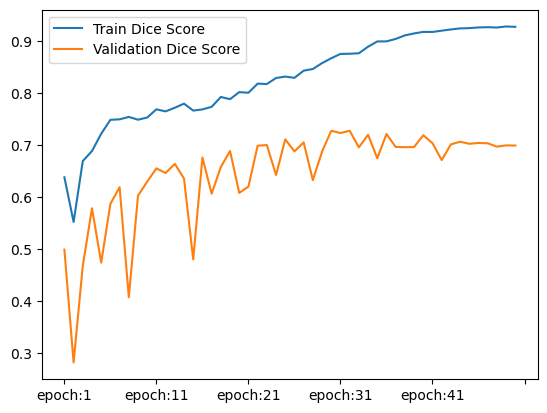

In [37]:
result_df[["Train Dice Score", "Validation Dice Score"]].plot()

<Axes: >

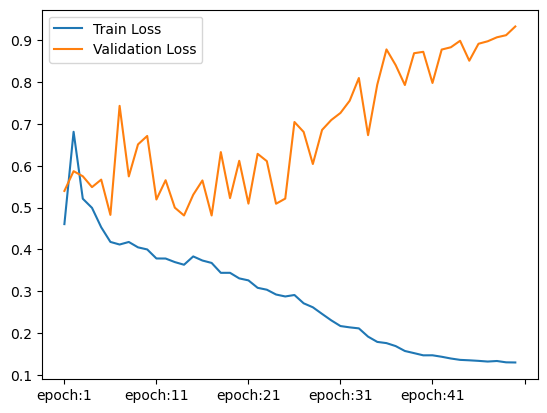

In [38]:
result_df[["Train Loss", "Validation Loss"]].plot()

In [32]:
# 모델 저장
# torch.save(infer_model.state_dict(), pth_name)

## Test

In [39]:
def Test(model, criterion, test_loader, device):
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(test_loader):
            out = model(img.to(device))
            out = torch.squeeze(out)
            pred = torch.ge(out.sigmoid(), 0.5).float()
            label = torch.squeeze(label).to(device)
            score = dice_score(pred, label)
            loss = criterion(out, label.type(torch.FloatTensor).to(device))

            loss_meter.update(loss.item())
            score_meter.update(score.item())
    
        test_loss_mean = loss_meter.avg
        test_score_mean = score_meter.avg
        loss_meter.reset()
        score_meter.reset()
    
    return test_loss_mean, test_score_mean

In [34]:
# model.load_state_dict(torch.load("data/pthfile/train:20X_test:20X_epoch:20_(2023_06_01_11:52_AM).pth", map_location=device))

In [40]:
test_loss, test_score = Test(infer_model, criterion, test_loader, device)
print(f"test_loss: {test_loss}, test_score: {test_score}")

  0%|          | 0/7 [00:00<?, ?it/s]

test_loss: 0.8538645761353629, test_score: 0.6673781956945147


## 결과 저장

In [41]:
def denormalize(tensor, mean=CFG["MEAN"], std=CFG["STD"]):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [42]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'inferno'

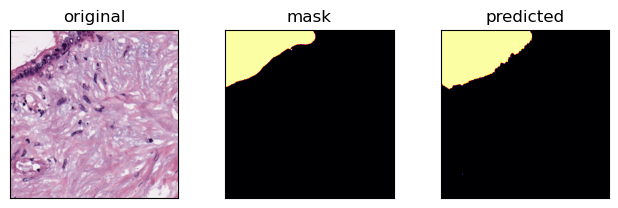

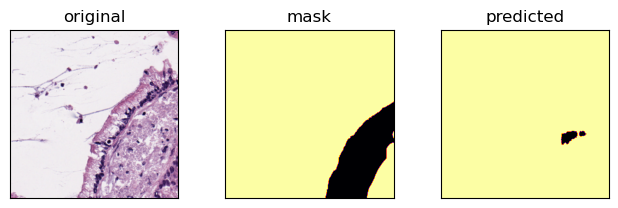

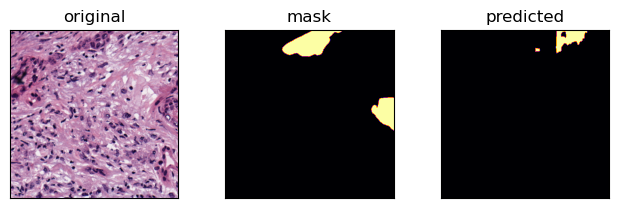

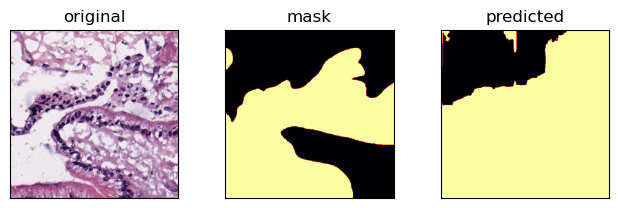

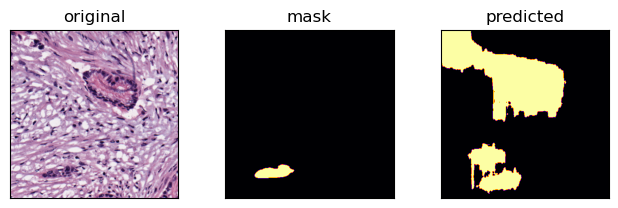

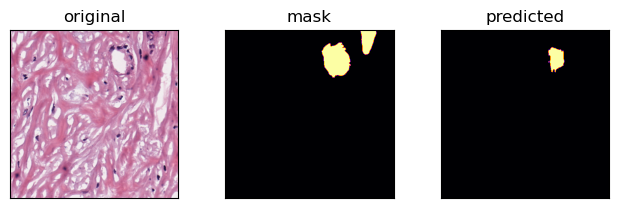

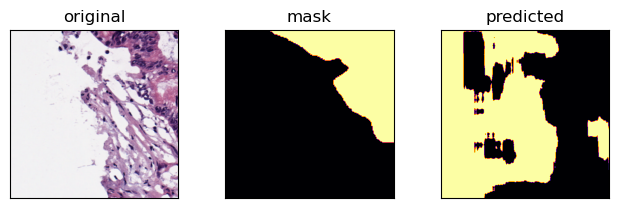

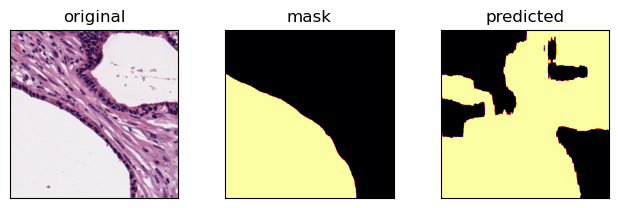

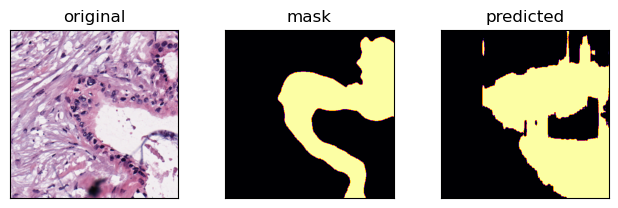

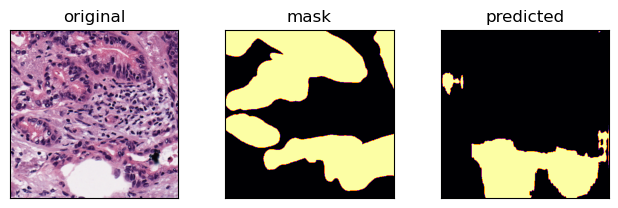

In [43]:
# output_save
os.makedirs(output_path, exist_ok=True)

for i in range(10):
    
    data, label = test_set[i]
    label = torch.squeeze(label)

    with torch.no_grad():
        out = model(torch.unsqueeze(data, dim=0).to(device))
    out = torch.squeeze(out).sigmoid().to('cpu')
    pred = torch.ge(out, 0.5).float().to('cpu')

    # 오리지널 이미지
    plt.subplot(1,3,1)
    plt.title("original")
    plt.imshow(ToPILImage()(denormalize(data)))
    plt.xticks([]); plt.yticks([])

    # 마스크 이미지
    plt.subplot(1,3,2)
    plt.title("mask")
    plt.imshow(label)
    plt.xticks([]); plt.yticks([])
    
    # 마스크 예측 이미지
    plt.subplot(1,3,3)
    plt.title("predicted")
    plt.tight_layout()
    plt.imshow(pred)
    plt.xticks([]); plt.yticks([])

    plt.show()
    # plt.savefig(f'{output_path}/{output_name}_{i+1}.png')